<a href="https://colab.research.google.com/github/factdroid/hand_washing/blob/master/Castles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification of CapeCoast and Elmina Castles in Ghana
by: [factsdroid](https://twitter.com/factsdroid)



The [Cape Coast](https://en.wikipedia.org/wiki/Cape_Coast_Castle) and [Elmina](https://en.wikipedia.org/wiki/Elmina_Castle) castles are located in the Central Region of Ghana.

## Mounting Google Drive for File I/O



In [0]:
#This will mount your gdrive and allow files to be stored permanently on gdrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from fastai.vision import *

## Creating the folders where the images will reside

In [0]:
path = Path('/content/gdrive/My Drive/fastai/data/ghanacastles')


In [0]:
#creating a folder for capecoast where all the capecoast images will go
folder = Path('train/capecoast')

In [0]:
cc_dest = path/folder
cc_dest.mkdir(parents=True, exist_ok=True)

In [0]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai/data/ghanacastles/train')]

In [0]:
#Doing same for elmina
folder = Path('train/elmina')

In [0]:
el_dest = path/folder
el_dest.mkdir(parents=True, exist_ok=True)

In [0]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai/data/ghanacastles/train')]

In [0]:
classes = ['capecoast','elmina']

## Downloading the Images from Google Using a CSV File of Urls
In order to get the image dataset for the castles. We searched for the castles on google. We tried to make the search as specific as possible. Considering that both castles are often mentioned together, we excluded each one while searching for the other.


> For Elmina Castle: "elmina castle" -capecoast -"Cape Coast Castle" -"capecoast castle"
>
> For Cape Coast Castle: "cape coast castle" -elmina -"elmina castle"

### Scrolling and Downloading
All the images scrolled past will be available for downloading. 

To download, we pressed CtrlShiftJ, the Javascript console appeared and the following was pasted in the console:
```
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

```
A csv of urls will be download unto your local drive. Name the file appropriately and upload to the right folder in GDrive. Do so for all the classes



### Warning: make sure CSV files have been uploaded into the relevant folders

In [0]:
#starting with the download of capecoast images
file = 'urls_capecoast.csv'

In [0]:
download_images(path/cc_dest/file, cc_dest, max_pics=200)

In [0]:
#starting with the download of elmina images
file = 'urls_elmina.csv'

In [0]:
download_images(path/el_dest/file, el_dest, max_pics=200)

###Further Image Cleaning

In [0]:
#Going through each folder and "verifying images"
for c in classes:
    print(c)
    verify_images(path/'train'/c, delete=True, max_size=500)

After this we went through the files and further pruned the dataset. We took out images that had been downloaded that were obviously neither of the two castles. 

## Creating a DataBunch: An ImageDataBunch

In [0]:
#creating an imagedatabunch that will have training, validation and test data
np.random.seed(42)
data = ImageDataBunch.from_folder(path, valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4)
#the default value for the train property of from_folder is "train". So it works fine as long as there is a "train folder within the path"
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (292 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
capecoast,capecoast,capecoast,capecoast,capecoast
Path: /content/gdrive/My Drive/fastai/data/ghanacastles;

Valid: LabelList (72 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
elmina,capecoast,capecoast,elmina,capecoast
Path: /content/gdrive/My Drive/fastai/data/ghanacastles;

Test: None

In [0]:
data.classes

['capecoast', 'elmina']

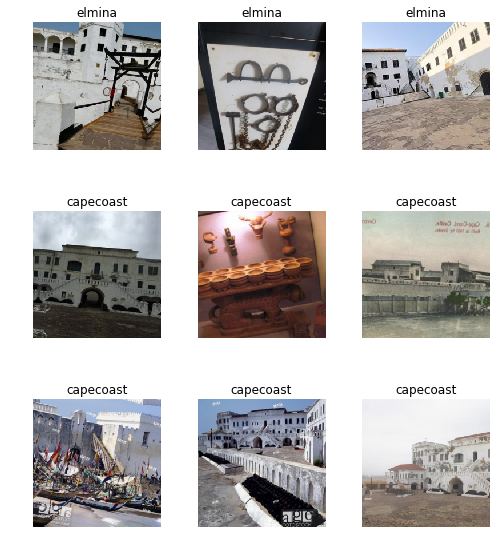

In [0]:
#looking at some of the data. It's actually better to just scroll through the folders on gdrive and check them out the images
data.show_batch(rows=3, figsize=(7,8))

## Traning the model

In [0]:
#Time to train the model
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 26524881.02it/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.861803,0.543147,0.277778,00:08
1,0.715465,0.671924,0.333333,00:06
2,0.640953,0.663517,0.263889,00:06
3,0.558612,0.561318,0.208333,00:06


In [0]:
#Let's see if we can improve the model even further

In [0]:
#first we save what we have now
learn.save('stage-1')

In [0]:
#now we unfreeze layers
learn.unfreeze()

In [0]:
#we find the learning rate and adjust to see if it will improve the model
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


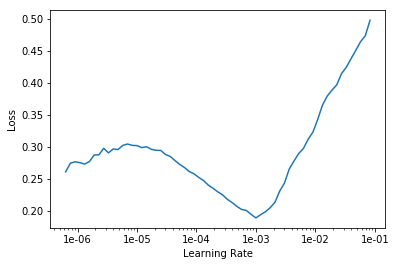

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))


epoch,train_loss,valid_loss,error_rate,time
0,0.370676,0.480577,0.166667,00:06
1,0.310801,0.467034,0.166667,00:06


A significant improvemtn in the error rate. So we go ahead and save this model as well

In [0]:
learn.save('stage-2')

## Interpreting the model

In [0]:
#Time to interpret
interp = ClassificationInterpretation.from_learner(learn)


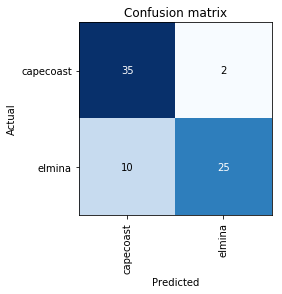

In [0]:
interp.plot_confusion_matrix()

In [0]:
doc(interp.plot_top_losses)

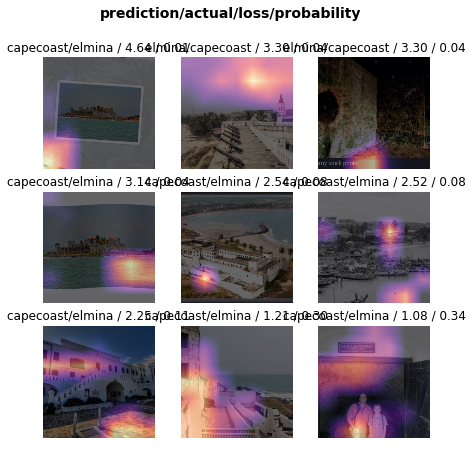

In [0]:
interp.plot_top_losses(9, figsize=(7,7))

## Testing the model with new data

In [0]:
#putting the model in production

learn.export()

In [0]:
defaults.device = torch.device('cpu')

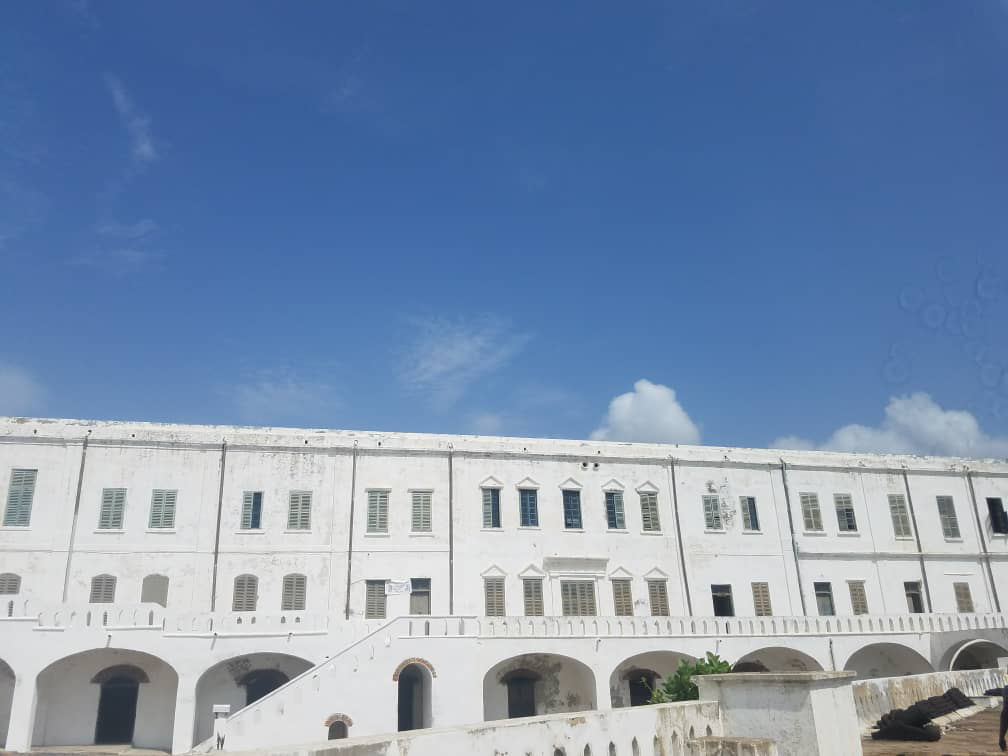

In [0]:
#I took this picture myself on a trip to the castle in the year 2017
img = open_image('/content/gdrive/My Drive/capecoastsample1.jpeg')
img

In [0]:
learn = load_learner(path)

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category capecoast

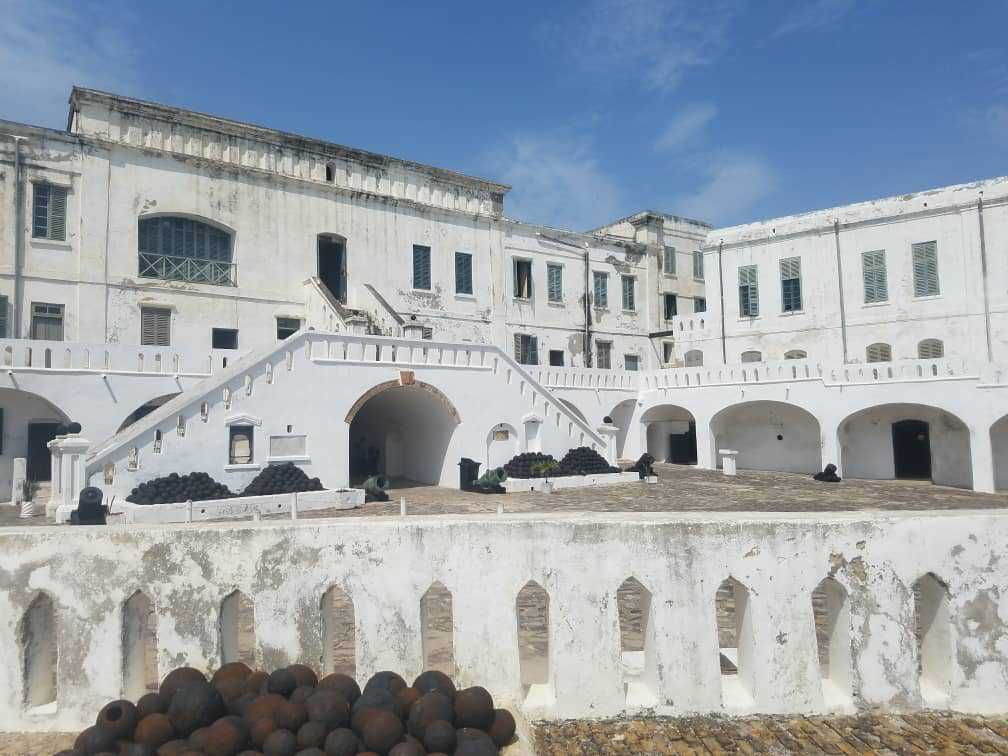

In [0]:
#I took this pic myself as well
img = open_image('/content/gdrive/My Drive/someplace.jpeg')
img


In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category capecoast